In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway


In [2]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================
"""
This cell performs the complete data preprocessing pipeline for the pie chart 
estimation experiment:

1. Loads answer key and survey response data
2. Standardizes column names and formats
3. Cleans and filters the data
4. Transforms data from wide to long format
5. Merges survey responses with correct answers
6. Calculates estimation errors

Input files:
- answers.csv: Contains correct answers for each pie chart question
- Pie charts(1-32).xlsx: Survey responses from participants
"""

# -----------------------------------------------------------------------------
# 1. LOAD ANSWER KEY DATA
# -----------------------------------------------------------------------------
print("Loading answer key data...")
try:
    df_answers = pd.read_csv('answers.csv')
    print(f"Loaded {len(df_answers)} correct answers")
    
    # Create standardized question identifiers
    df_answers["Question"] = "Question_" + df_answers["index"].astype(str)
    
except FileNotFoundError:
    print("❌ Error: answers.csv file not found")
    raise
except Exception as e:
    print(f"❌ Error loading answers.csv: {e}")
    raise

# -----------------------------------------------------------------------------
# 2. LOAD SURVEY RESPONSE DATA
# -----------------------------------------------------------------------------
print("\nLoading survey response data...")
try:
    df = pd.read_excel('Pie charts(1-32).xlsx')
    print(f"Loaded {len(df)} participant responses")
    print(f"Original columns: {len(df.columns)}")
    
except FileNotFoundError:
    print("❌ Error: Pie charts(1-32).xlsx file not found")
    raise
except Exception as e:
    print(f"❌ Error loading survey data: {e}")
    raise

# -----------------------------------------------------------------------------
# 3. CLEAN AND STANDARDIZE COLUMN NAMES
# -----------------------------------------------------------------------------
print("\nCleaning and standardizing data...")

# Remove personally identifiable information
df = df.drop(['Email', 'Name'], axis=1, errors='ignore')
print(f"Removed PII columns, {len(df.columns)} columns remaining")

# Standardize email column name (if it exists with different variants)
df.columns = ['Mail' if col.lower().startswith('enter') else col for col in df.columns]

# -----------------------------------------------------------------------------
# 4. RENAME QUESTION COLUMNS TO STANDARDIZED FORMAT
# -----------------------------------------------------------------------------
# Identify question columns by their content pattern
question_identifier = 'What percentage of the pie chart is represented by the gray section?'
question_cols = [col for col in df.columns if question_identifier in col]
print(f"Found {len(question_cols)} question columns")

# Sort columns by their original order in the DataFrame
question_cols_sorted = sorted(question_cols, key=lambda x: df.columns.get_loc(x))

# Generate standardized question names: Question_-1, Question_0, Question_1, etc.
# Note: Starting from -1 to accommodate example questions
new_names = [f'Question_{i}' for i in range(-1, -1 + len(question_cols_sorted))]

# Create mapping and apply renaming
rename_map = dict(zip(question_cols_sorted, new_names))
df.rename(columns=rename_map, inplace=True)

# Rename example questions to more descriptive names
df.rename(columns={
    'Question_-1': 'Example_1',
    'Question_0': 'Example_2'
}, inplace=True)

print("Standardized question column names")

# -----------------------------------------------------------------------------
# 5. CALCULATE SURVEY COMPLETION METRICS
# -----------------------------------------------------------------------------
# Calculate survey duration in seconds
if 'Completion time' in df.columns and 'Start time' in df.columns:
    df['Duration_seconds'] = (df['Completion time'] - df['Start time']).dt.total_seconds()
    avg_duration = df['Duration_seconds'].mean() / 60  # Convert to minutes
    print(f"Calculated survey duration (avg: {avg_duration:.1f} minutes)")

# -----------------------------------------------------------------------------
# 6. DATA QUALITY FILTERING
# -----------------------------------------------------------------------------
# Remove incomplete responses (participants who didn't answer all questions)
initial_count = len(df)
df = df[df['Question_20'].notna()]  # Filter based on last question
filtered_count = len(df)
print(f"Removed {initial_count - filtered_count} incomplete responses")
print(f"{filtered_count} complete participant responses remaining")

# Standardize participant IDs to start from 1
if 'ID' in df.columns:
    original_ids = df['ID'].copy()
    df['ID'] = df['ID'] - 2  # Adjust based on your data structure
    print(f"Adjusted participant IDs (now range: {df['ID'].min()} to {df['ID'].max()})")

# -----------------------------------------------------------------------------
# 7. TRANSFORM DATA FROM WIDE TO LONG FORMAT
# -----------------------------------------------------------------------------
print("\nTransforming data structure...")

# Define columns to keep as identifiers (non-melted columns)
id_vars = ['ID', 'Start time', 'Completion time', 'Mail', 'Duration_seconds']
id_vars = [col for col in id_vars if col in df.columns]  # Only keep existing columns

# Identify question columns (all others not in id_vars)
value_vars = [col for col in df.columns if col not in id_vars]
print(f"Identified {len(value_vars)} question columns for melting")

# Transform from wide to long format
df_melted = df.melt(
    id_vars=id_vars, 
    value_vars=value_vars,
    var_name='Question', 
    value_name='Answer'
)

print(f"Transformed to long format: {len(df_melted)} total responses")

# -----------------------------------------------------------------------------
# 8. MERGE WITH CORRECT ANSWERS AND CALCULATE ERRORS
# -----------------------------------------------------------------------------
print("\nMerging with answer key and calculating errors...")

# Merge survey responses with correct answers
df_joined = pd.merge(df_melted, df_answers, on="Question", how="left")
print(f"Merged responses with answer key")

# Remove example questions from analysis
example_questions = ['Example_1', 'Example_2']
df_joined = df_joined[~df_joined['Question'].isin(example_questions)]
analysis_responses = len(df_joined)
print(f"Excluded example questions, {analysis_responses} responses for analysis")

# Calculate estimation error (correct answer - participant answer)
df_joined['difference'] = df_joined['number'] - df_joined['Answer']
print(f"Calculated estimation errors")

# -----------------------------------------------------------------------------
# 9. DATA SUMMARY
# -----------------------------------------------------------------------------
print(f"\n{'='*50}")
print("DATA PREPROCESSING COMPLETE")
print(f"{'='*50}")
print(f"Final dataset shape: {df_joined.shape}")
print(f"Participants: {df_joined['ID'].nunique()}")
print(f"Questions per participant: {len(df_joined) // df_joined['ID'].nunique()}")
print(f"Error range: {df_joined['difference'].min():.1f} to {df_joined['difference'].max():.1f}")
print(f"Mean absolute error: {df_joined['difference'].abs().mean():.2f}")
print(f"{'='*50}")

# Display sample of final dataset
print("\nSample of processed data:")
df_joined.head()

Loading answer key data...
Loaded 20 correct answers

Loading survey response data...
Loaded 32 participant responses
Original columns: 28

Cleaning and standardizing data...
Removed PII columns, 26 columns remaining
Found 22 question columns
Standardized question column names
Calculated survey duration (avg: 5.3 minutes)
Removed 1 incomplete responses
31 complete participant responses remaining
Adjusted participant IDs (now range: 1 to 32)

Transforming data structure...
Identified 22 question columns for melting
Transformed to long format: 682 total responses

Merging with answer key and calculating errors...
Merged responses with answer key
Excluded example questions, 620 responses for analysis
Calculated estimation errors

DATA PREPROCESSING COMPLETE
Final dataset shape: (620, 15)
Participants: 31
Questions per participant: 20
Error range: -83.0 to 86.0
Mean absolute error: 3.69

Sample of processed data:


,ID,Start time,Completion time,Mail,Duration_seconds,Question,Answer,Unnamed: 0,index,number,angle,start_angle,size,Orientation,difference
62,1,2025-06-10 13:08:53,2025-06-10 13:12:31,anonymized,218.0,Question_1,60.0,0.0,1.0,67.0,241.2,-1.053939,big,NaN,7.0
63,2,2025-06-10 13:10:53,2025-06-10 13:17:16,anonymized,383.0,Question_1,92.0,0.0,1.0,67.0,241.2,-1.053939,big,NaN,-25.0
64,3,2025-06-10 13:30:12,2025-06-10 13:33:37,anonymized,205.0,Question_1,70.0,0.0,1.0,67.0,241.2,-1.053939,big,NaN,-3.0
65,4,2025-06-10 14:20:57,2025-06-10 14:27:44,anonymized,407.0,Question_1,68.0,0.0,1.0,67.0,241.2,-1.053939,big,NaN,-1.0
66,5,2025-06-10 14:49:43,2025-06-10 14:55:10,anonymized,327.0,Question_1,70.0,0.0,1.0,67.0,241.2,-1.053939,big,NaN,-3.0


Creating participant error distribution visualization...


c:\Users\stijndp\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\stijndp\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


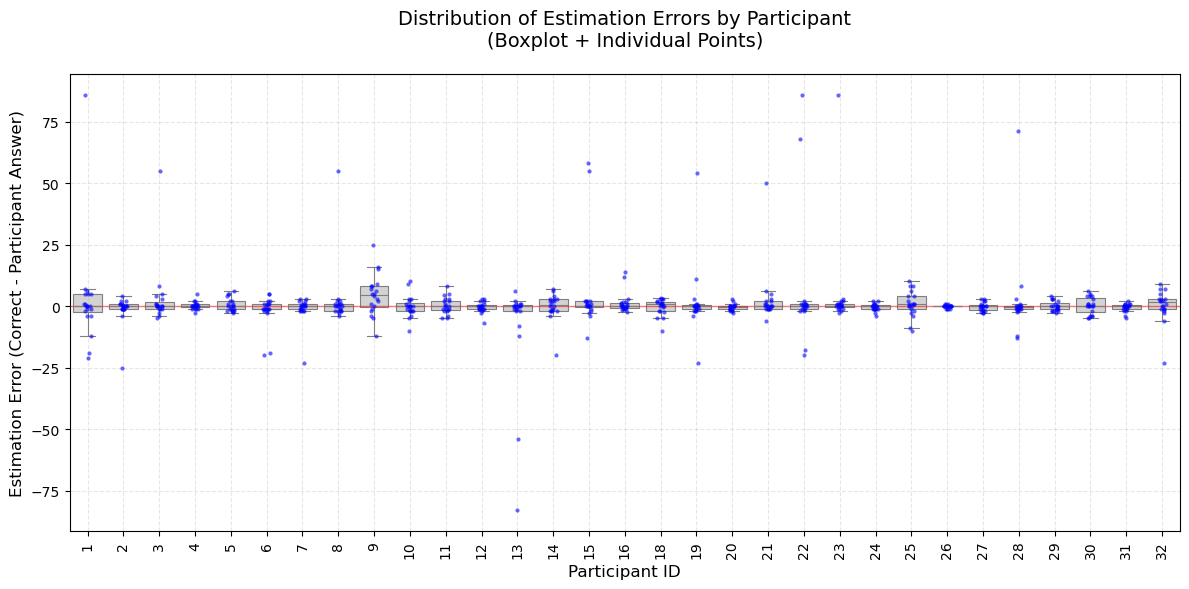

Visualization complete for 31 participants
Error range: -83.0 to 86.0
Mean absolute error across all participants: 3.69


In [3]:
# =============================================================================
# VISUALIZATION: PARTICIPANT ERROR DISTRIBUTION (NO OUTLIERS)
# =============================================================================
"""
Creates a combined boxplot and stripplot to visualize the distribution of 
estimation errors for each participant. This visualization helps identify:

1. Individual participant performance patterns
2. Consistency of errors within participants  
3. Overall spread of errors across the sample
4. Participants with unusual error patterns

Note: Outliers are hidden in boxplot but individual points are shown via stripplot
"""

print("Creating participant error distribution visualization...")

# Set up the figure with appropriate size for readability
plt.figure(figsize=(12, 6))

# Create boxplot showing quartiles and median for each participant
# showfliers=False hides outliers to focus on central tendency
sns.boxplot(
    x='ID', 
    y='difference', 
    data=df_joined, 
    color='lightgray', 
    showfliers=False,
    linewidth=0.8
)

# Overlay individual data points to show all responses
# jitter=True prevents points from overlapping
# alpha=0.6 makes points semi-transparent for better visibility
sns.stripplot(
    x='ID', 
    y='difference', 
    data=df_joined, 
    jitter=True, 
    color='blue', 
    alpha=0.6,
    size=3
)

# Customize plot appearance and labels
plt.xlabel('Participant ID', fontsize=12)
plt.ylabel('Estimation Error (Correct - Participant Answer)', fontsize=12)
plt.title('Distribution of Estimation Errors by Participant\n(Boxplot + Individual Points)', 
          fontsize=14, pad=20)

# Rotate x-axis labels for better readability with many participants
plt.xticks(rotation=90)

# Add grid for easier reading of values
plt.grid(True, alpha=0.3, linestyle='--')

# Add horizontal line at y=0 to highlight perfect accuracy
plt.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

# Optimize layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Print summary statistics
n_participants = df_joined['ID'].nunique()
print(f"Visualization complete for {n_participants} participants")
print(f"Error range: {df_joined['difference'].min():.1f} to {df_joined['difference'].max():.1f}")
print(f"Mean absolute error across all participants: {df_joined['difference'].abs().mean():.2f}")

Creating zoomed participant error distribution with outliers...


c:\Users\stijndp\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\stijndp\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


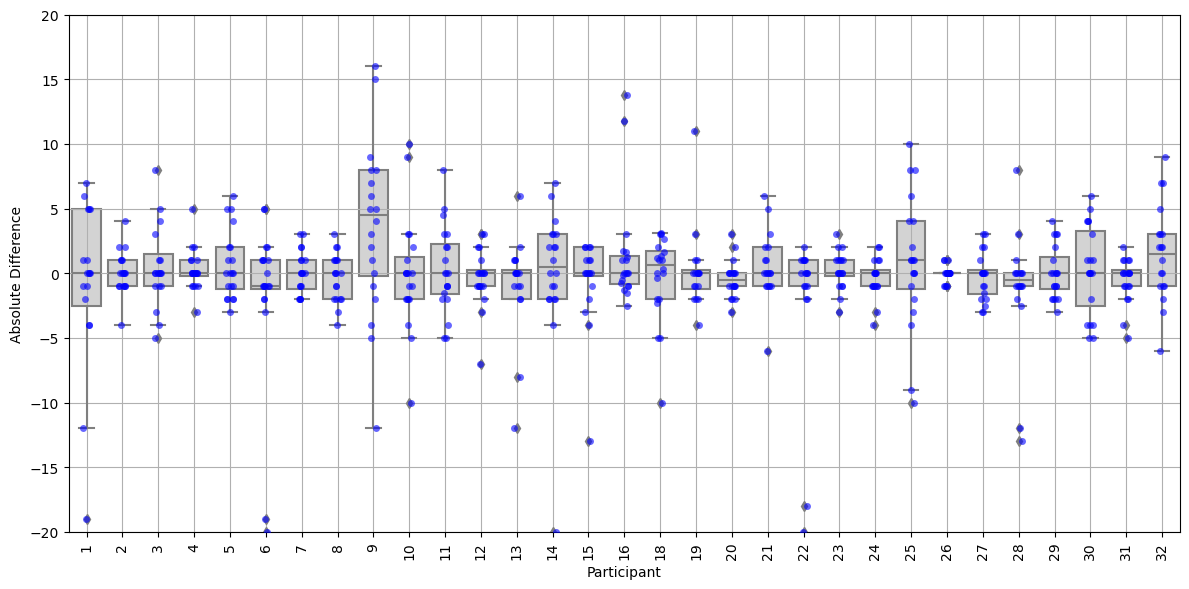

Zoomed visualization complete for 31 participants
Zoom range: ±20 percentage points
Responses within zoom range: 601 (96.9%)
Responses beyond zoom range: 19 (3.1%)
Participants with extreme errors: 14 of 31


In [4]:
# =============================================================================
# VISUALIZATION: PARTICIPANT ERROR DISTRIBUTION (WITH OUTLIERS, ZOOMED)
# =============================================================================
"""
Creates a detailed view of estimation errors with outliers visible and 
y-axis zoomed to focus on the main distribution range (-20 to +20).

This visualization complements the previous plot by:
1. Showing outliers as individual points beyond the whiskers
2. Focusing on the central range where most errors occur
3. Identifying extreme estimation errors that may need special attention
4. Providing better resolution for the main error distribution
"""

print("Creating zoomed participant error distribution with outliers...")

# Set up the figure with appropriate dimensions
plt.figure(figsize=(12, 6))

# Create boxplot with all outliers visible (showfliers=True)
sns.boxplot(x='ID', y='difference', data=df_joined, color='lightgray', showfliers=True)

# Overlay individual data points to show all responses
sns.stripplot(x='ID', y='difference', data=df_joined, jitter=True, color='blue', alpha=0.6)

# Focus on the main distribution range (-20 to +20)
plt.ylim(-20, 20)

# Customize labels and layout
plt.xlabel('Participant')
plt.ylabel('Absolute Difference')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# ANALYSIS: SUMMARY STATISTICS
# =============================================================================

# Calculate basic statistics for the zoomed view
zoom_limit = 20
outliers_beyond_range = df_joined[
    (df_joined['difference'] < -zoom_limit) | 
    (df_joined['difference'] > zoom_limit)
]

n_outliers = len(outliers_beyond_range)
total_responses = len(df_joined)
n_participants = df_joined['ID'].nunique()

# Display summary information
print(f"Zoomed visualization complete for {n_participants} participants")
print(f"Zoom range: ±{zoom_limit} percentage points")
print(f"Responses within zoom range: {total_responses - n_outliers:,} ({(total_responses - n_outliers)/total_responses*100:.1f}%)")
print(f"Responses beyond zoom range: {n_outliers:,} ({n_outliers/total_responses*100:.1f}%)")

if n_outliers > 0:
    participants_with_outliers = outliers_beyond_range['ID'].nunique()
    print(f"Participants with extreme errors: {participants_with_outliers} of {n_participants}")

In [5]:
# =============================================================================
# DATA FILTERING: OUTLIER REMOVAL
# =============================================================================
"""
Remove extreme outliers (beyond ±20) to focus on main distribution.
"""

print("Applying outlier filtering...")

# Remove outliers from df_joined
df = df_joined[(df_joined['difference'] >= -20) & (df_joined['difference'] <= 20)].copy()

print(f"Filtered dataset: {len(df_joined)} → {len(df)} responses ({len(df_joined)-len(df)} removed)")


Applying outlier filtering...
Filtered dataset: 620 → 601 responses (19 removed)


In [6]:
# =============================================================================
# ERROR METRICS: OVERALL ESTIMATION ACCURACY
# =============================================================================
"""
Calculate key accuracy metrics for estimation performance.
"""

# Extract filtered error values
differences = df['difference']

# Calculate core metrics
mae = differences.abs().mean()  # Mean Absolute Error
sd = differences.std()          # Standard Deviation
rmse = np.sqrt((differences ** 2).mean())  # Root Mean Square Error
sem = sd / np.sqrt(len(differences))       # Standard Error of Mean

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Standard Deviation (SD): {sd:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Standard Error of Mean (SEM): {sem:.2f}")
print(f"Sample size: {len(differences):,} responses")

Mean Absolute Error (MAE): 2.14
Standard Deviation (SD): 3.70
Root Mean Square Error (RMSE): 3.70
Standard Error of Mean (SEM): 0.15
Sample size: 601 responses


In [7]:
# =============================================================================
# ANALYSIS: ESTIMATION ACCURACY BY SEGMENT SIZE
# =============================================================================
"""
Compare estimation accuracy between different pie chart segment sizes.
"""

# Group by segment size and calculate mean absolute error
grouped_mae = df.groupby('size')['difference'].apply(lambda x: x.abs().mean())

# Print results
for size, mae in grouped_mae.items():
    print(f"Mean Absolute Error for segment size '{size}': {mae:.2f} percentage points")

Mean Absolute Error for segment size 'big': 2.22 percentage points
Mean Absolute Error for segment size 'small': 2.33 percentage points


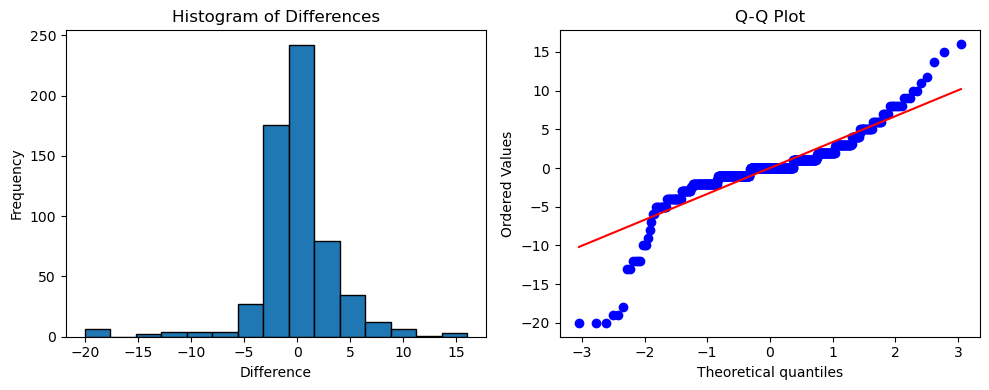

In [8]:
# =============================================================================
# VISUALIZATION: ERROR DISTRIBUTION ANALYSIS
# =============================================================================
"""
Examine the distribution shape of estimation errors using histogram and Q-Q plot.
"""

# Create side-by-side visualization
plt.figure(figsize=(10, 4))

# Histogram shows overall distribution shape
plt.subplot(1, 2, 1)
plt.hist(differences, bins=15, edgecolor='black')
plt.title('Histogram of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')

# Q-Q plot tests normality assumption
plt.subplot(1, 2, 2)
stats.probplot(differences, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [9]:
# =============================================================================
# ANALYSIS: INDIVIDUAL PARTICIPANT PERFORMANCE METRICS
# =============================================================================
"""
Calculate standard deviation and mean absolute error for each participant.
"""

# Group by participant ID and calculate SD and MAE
participant_stats = df.groupby('ID')['difference'].agg(
    SD='std',
    MAE=lambda x: x.abs().mean()
).reset_index()

# Display the results
print(participant_stats)

    ID        SD       MAE
0    1  6.396741  4.055556
1    2  1.649029  1.105263
2    3  3.040660  1.947368
3    4  1.585294  0.950000
4    5  2.643761  2.000000
5    6  6.440824  3.500000
6    7  1.629408  1.263158
7    8  1.857496  1.473684
8    9  6.760307  5.947368
9   10  4.370656  2.850000
10  11  3.353710  2.550000
11  12  2.207046  1.450000
12  13  3.817743  2.111111
13  14  5.500957  3.350000
14  15  3.514675  1.888889
15  16  4.126026  2.192250
16  18  3.309586  2.344500
17  19  3.091735  1.611111
18  20  1.394538  1.050000
19  21  2.546641  1.631579
20  22  6.248660  2.888889
21  23  1.436777  1.052632
22  24  1.460894  1.050000
23  25  5.132712  3.750000
24  26  0.604805  0.350000
25  27  1.810060  1.350000
26  28  4.559387  2.500000
27  29  2.012461  1.550000
28  30  3.416292  2.650000
29  31  1.700619  1.150000
30  32  3.716566  3.052632


In [10]:
# =============================================================================
# STATISTICAL TESTING: SHAPIRO-WILK NORMALITY TEST
# =============================================================================
"""
Test normality of error distributions using Shapiro-Wilk test per participant.
"""


def _shapiro_safe(x):
    """
    Run Shapiro-Wilk on a 1D array-like.
    Returns: dict with n, W, p_value, status.
    """
    vals = pd.Series(x).astype(float).values
    n = len(vals)
    out = {"n": n, "statistic_W": np.nan, "p_value": np.nan}
    W, p = stats.shapiro(vals)
    out["statistic_W"] = float(W)
    out["p_value"] = float(p)

    return out


def normality_shapiro(
    df: pd.DataFrame,
    id_col: str = "ID",
    value_col: str = "difference",
    alpha: float = 0.05,
    adjust: str | None = None,  # options: None, 'fdr_bh', 'bonferroni'
    test_overall: bool = True
):
    """
    One-test normality check (Shapiro-Wilk).

    Parameters
    ----------
    df : DataFrame with columns [id_col, value_col]
    id_col : group column, e.g. 'ID'
    value_col : numeric column to test, e.g. 'difference'
    alpha : significance level for decisions


    Returns
    -------
    results : DataFrame with per-participant results
    overall : dict with overall results (or None if test_overall=False)
    """
    # --- Per-participant ---
    rows = []
    for pid, g in df[[id_col, value_col]].groupby(id_col, dropna=False):
        res = _shapiro_safe(g[value_col])
        rows.append({
            id_col: pid,
            "n": res["n"],
            "statistic_W": res["statistic_W"],
            "p_value": res["p_value"],
        })
    results = pd.DataFrame(rows)

    # Raw decision
    results["reject_H0"] = (results["p_value"] < alpha)


    # Order by evidence against normality (smallest p-values first)
    results = results.sort_values("p_value", na_position="last").reset_index(drop=True)

    # --- Overall (all results combined) ---
    overall = None
    if test_overall:
        o = _shapiro_safe(df[value_col])
        overall = {
            "n": o["n"],
            "statistic_W": o["statistic_W"],
            "p_value": o["p_value"],
            "reject_H0": (o["p_value"] < alpha) if pd.notna(o["p_value"]) else np.nan,
        }

    return results, overall


# Run normality tests
alpha = 0.05
results_shapiro, overall_shapiro = normality_shapiro(
    df, id_col="ID", value_col="difference", alpha=alpha,
    adjust=None,      # keep None to stick to one-test reporting
    test_overall=True
)

print("=== Shapiro-Wilk per participant ===")
print(results_shapiro.head(10))
print(f"\nNon-normal (raw, p<{alpha}): {results_shapiro['reject_H0'].sum()} of {len(results_shapiro)}")

print("\n=== Shapiro-Wilk overall (all results combined) ===")
print(overall_shapiro)

=== Shapiro-Wilk per participant ===
   ID   n  statistic_W   p_value  reject_H0
0  22  18     0.541064  0.000002       True
1  16  20     0.656962  0.000012       True
2   6  20     0.661177  0.000014       True
3  15  18     0.672866  0.000039       True
4  19  18     0.703347  0.000087       True
5  14  20     0.745407  0.000147       True
6  28  19     0.748388  0.000223       True
7  26  20     0.767682  0.000296       True
8  13  18     0.784773  0.000933       True
9  18  20     0.852961  0.005978       True

Non-normal (raw, p<0.05): 15 of 31

=== Shapiro-Wilk overall (all results combined) ===
{'n': 601, 'statistic_W': 0.8173326849937439, 'p_value': 1.476085094672865e-25, 'reject_H0': True}


In [11]:
# =============================================================================
# STATISTICAL RESULTS: NORMALITY TEST INTERPRETATION
# =============================================================================
"""
Format and interpret Shapiro-Wilk normality test results.
"""

def _fmt_p(p):
    if pd.isna(p):
        return "NA"
    if p < 1e-4:
        return f"{p:.2e}"
    return f"{p:.4f}"


def print_normality_conclusions(
    results: pd.DataFrame,
    overall: dict | None,
    alpha: float = 0.05,
    adjust: str | None = None,
    per_participant: bool = True,
    max_lines: int | None = None
):
    """
    Pretty-print scientific conclusions based on p vs alpha.
    """
    alpha_str = f"{alpha:.3f}".rstrip('0').rstrip('.')
    header = "Shapiro–Wilk normality test (one test per group)"
    if adjust:
        header += f" + multiple-testing correction ({adjust})"
    print("=" * len(header))
    print(header)
    print("=" * len(header))
    print(f"Null hypothesis H0: data in a group are drawn from a normal distribution.")
    print(f"Decision rule: if p < α={alpha_str} ⇒ Reject H0 (evidence against normality).")
    print(f"               if p ≥ α={alpha_str} ⇒ Fail to reject H0 (no sufficient evidence of non-normality).")
    print()

    # Optionally limit how many lines to print
    dfp = results.copy()
    if max_lines is not None:
        dfp = dfp.head(max_lines)

    if per_participant:
        for _, r in dfp.iterrows():
            pid = r.get("ID", "NA")
            n = int(r["n"]) if pd.notna(r["n"]) else np.nan
            W = r["statistic_W"]
            p = r["p_value"]
            padj = r.get("p_value_adj", np.nan)


            decision_raw = "REJECT H0 (non-normality detected)" if (p < alpha) else "fail to reject H0 (no sufficient evidence of non-normality)"
            line = f"- ID {pid}: n={n}, W={W:.4f}, p={_fmt_p(p)} ⇒ {decision_raw}"
            if adjust and pd.notna(padj):
                decision_adj = "REJECT H0 after adjustment" if (r.get("reject_H0_adj", False)) else "fail to reject H0 after adjustment"
                line += f" | adjusted p={_fmt_p(padj)} ⇒ {decision_adj}"
            print(line)

        if max_lines is not None and len(results) > max_lines:
            print(f"... ({len(results) - max_lines} more participants not shown)")

        print()

    # Summary counts
    print(results)
    n_total = len(results)
    n_rej = results["reject_H0"].sum()
    print("Summary (per participant):")
    print(f"- Reject H0 (p < α): {n_rej} groups")


    # Overall (combined)
    if overall is not None:
        o = overall

        decision = "REJECT H0 (non-normality detected overall)" if (o["p_value"] < alpha) else \
                    "fail to reject H0 (no sufficient evidence of overall non-normality)"
        print("Overall (all results combined):")
        print(f"- n={int(o['n'])}, W={o['statistic_W']:.4f}, p={_fmt_p(o['p_value'])} ⇒ {decision}")
        print()

    # Scientific caveat
    print("Notes:")
    print("- \"Fail to reject H0\" does not prove normality; it only indicates a lack of evidence against it.")
    print("- With larger samples, even small deviations can yield p < α; use Q–Q plots for context if needed.")
    print("- If many groups are tested, consider FDR (set adjust='fdr_bh') to control false discoveries.")
    print()


# Print formatted results
alpha = 0.05
results_shapiro, overall_shapiro = normality_shapiro(
    df, id_col="ID", value_col="difference", alpha=alpha,
    adjust=None,        # keep None to stick to single-test reporting
    test_overall=True
)
print_normality_conclusions(results_shapiro, overall_shapiro, alpha=alpha, adjust=None,
                            per_participant=True, max_lines=None)

Shapiro–Wilk normality test (one test per group)
Null hypothesis H0: data in a group are drawn from a normal distribution.
Decision rule: if p < α=0.05 ⇒ Reject H0 (evidence against normality).
               if p ≥ α=0.05 ⇒ Fail to reject H0 (no sufficient evidence of non-normality).

- ID 22: n=18, W=0.5411, p=1.86e-06 ⇒ REJECT H0 (non-normality detected)
- ID 16: n=20, W=0.6570, p=1.22e-05 ⇒ REJECT H0 (non-normality detected)
- ID 6: n=20, W=0.6612, p=1.36e-05 ⇒ REJECT H0 (non-normality detected)
- ID 15: n=18, W=0.6729, p=3.93e-05 ⇒ REJECT H0 (non-normality detected)
- ID 19: n=18, W=0.7033, p=8.74e-05 ⇒ REJECT H0 (non-normality detected)
- ID 14: n=20, W=0.7454, p=0.0001 ⇒ REJECT H0 (non-normality detected)
- ID 28: n=19, W=0.7484, p=0.0002 ⇒ REJECT H0 (non-normality detected)
- ID 26: n=20, W=0.7677, p=0.0003 ⇒ REJECT H0 (non-normality detected)
- ID 13: n=18, W=0.7848, p=0.0009 ⇒ REJECT H0 (non-normality detected)
- ID 18: n=20, W=0.8530, p=0.0060 ⇒ REJECT H0 (non-normality dete

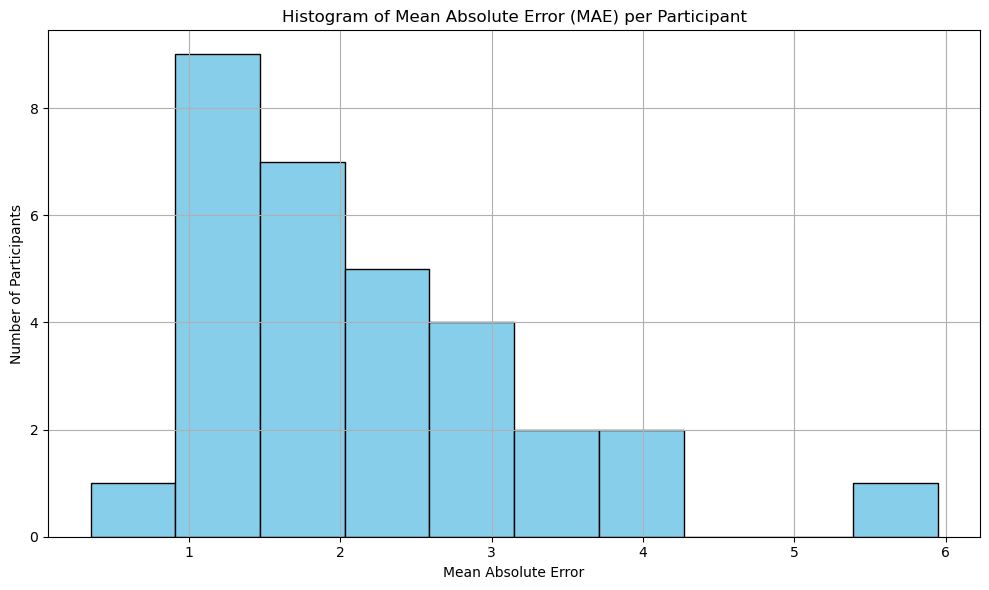

In [12]:
# =============================================================================
# VISUALIZATION: PARTICIPANT PERFORMANCE DISTRIBUTION
# =============================================================================
"""
Visualize the distribution of individual participant performance (MAE).
"""



# Remove outliers beyond ±20 (consistent with previous filtering)
df = df_joined[(df_joined['difference'] >= -20) & (df_joined['difference'] <= 20)]

# Calculate MAE per participant
mae_per_participant = df.groupby('ID')['difference'].apply(lambda x: x.abs().mean())

# Plot histogram of MAE values
plt.figure(figsize=(10, 6))
plt.hist(mae_per_participant, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Mean Absolute Error (MAE) per Participant')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Number of Participants')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# =============================================================================
# EXAMPLE: SIMULATED ANOVA TEST
# =============================================================================
"""
Demonstrate ANOVA testing with simulated data for comparison.
"""




# Simulate data for demonstration
np.random.seed(42)
n_participants = 30
n_estimations = 20

data = {
    'ID': np.repeat(np.arange(1, n_participants + 1), n_estimations),
    'difference': np.random.exponential(scale=1.0, size=n_participants * n_estimations)
}
df_data = pd.DataFrame(data)

# Perform ANOVA on simulated data
groups = [df_data[df_data['ID'] == pid]['difference'].values for pid in df_data['ID'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f"F-statistiek = {f_stat:.4f}, P-waarde = {p_value:.4f}")

F-statistiek = 1.4398, P-waarde = 0.0656


Mean MAE for 'big' graphs: 0.3040
Mean MAE for 'small' graphs: -0.1119
ANOVA F-statistic: 1.3312
P-value: 0.2492


<Figure size 800x600 with 0 Axes>

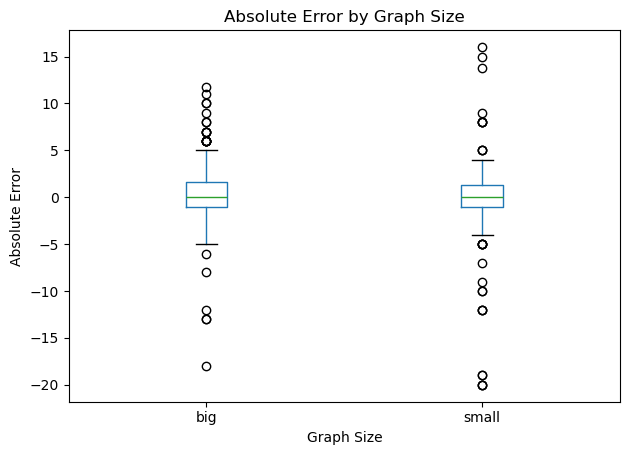

In [14]:
# =============================================================================
# ANALYSIS: SEGMENT SIZE COMPARISON (BIG vs SMALL)
# =============================================================================
"""
Compare estimation accuracy between big and small pie chart segments using ANOVA.
"""


df_temp = df.copy()

# Keep only 'big' and 'small' segments
df_temp = df_temp[df_temp['size'].isin(['big', 'small'])].copy()

# Calculate mean errors for each group
mean_mae_big = df_temp[df_temp['size'] == 'big']['difference'].mean()
mean_mae_small = df_temp[df_temp['size'] == 'small']['difference'].mean()

# Perform one-way ANOVA
big_errors = df_temp[df_temp['size'] == 'big']['difference']
small_errors = df_temp[df_temp['size'] == 'small']['difference']
f_stat, p_value = f_oneway(big_errors, small_errors)

# Print statistical results
print(f"Mean MAE for 'big' graphs: {mean_mae_big:.4f}")
print(f"Mean MAE for 'small' graphs: {mean_mae_small:.4f}")
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Visualize comparison
plt.figure(figsize=(8, 6))
df_temp.boxplot(column='difference', by='size', grid=False)
plt.title('Absolute Error by Graph Size')
plt.suptitle('')
plt.xlabel('Graph Size')
plt.ylabel('Absolute Error')
plt.tight_layout()
plt.show()

Mean MAE for 'Bottom' graphs: -0.6592
Mean MAE for 'Top' graphs: 0.4399
ANOVA F-statistic: 4.0771
P-value: 0.0446


<Figure size 800x600 with 0 Axes>

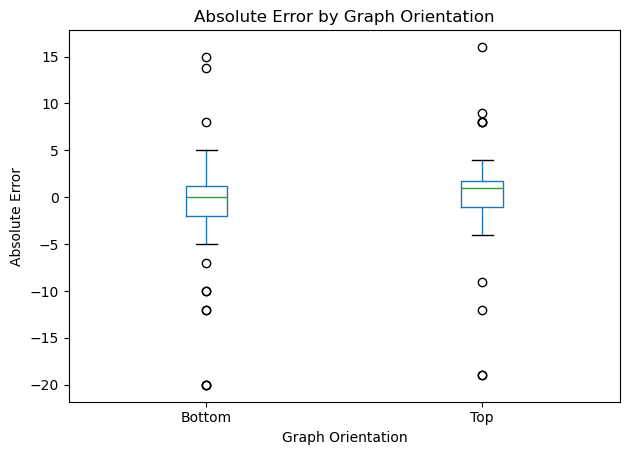

In [15]:
# =============================================================================
# ANALYSIS: ORIENTATION COMPARISON (BOTTOM vs TOP)
# =============================================================================
"""
Compare estimation accuracy between bottom and top pie chart orientations using ANOVA.
"""


df_temp = df.copy()

# Keep only 'Bottom' and 'Top' orientations
df_temp = df_temp[df_temp['Orientation'].isin(['Bottom', 'Top'])].copy()

# Calculate mean errors for each group
mean_mae_bottom = df_temp[df_temp['Orientation'] == 'Bottom']['difference'].mean()
mean_mae_top = df_temp[df_temp['Orientation'] == 'Top']['difference'].mean()

# Perform one-way ANOVA
bottom_errors = df_temp[df_temp['Orientation'] == 'Bottom']['difference']
top_errors = df_temp[df_temp['Orientation'] == 'Top']['difference']
f_stat, p_value = f_oneway(bottom_errors, top_errors)

# Print statistical results
print(f"Mean MAE for 'Bottom' graphs: {mean_mae_bottom:.4f}")
print(f"Mean MAE for 'Top' graphs: {mean_mae_top:.4f}")
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Visualize comparison
plt.figure(figsize=(8, 6))
df_temp.boxplot(column='difference', by='Orientation', grid=False)
plt.title('Absolute Error by Graph Orientation')
plt.suptitle('')
plt.xlabel('Graph Orientation')
plt.ylabel('Absolute Error')
plt.tight_layout()
plt.show()